In [1]:
import pandas as pd

import numpy as np
import sys, os
from scipy import stats
import collections
import math
import statistics

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib

matplotlib.rcParams['xtick.major.size'] = 8
matplotlib.rcParams['xtick.major.width'] = 2.5
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['xtick.minor.size'] = 4
matplotlib.rcParams['xtick.minor.width'] = 1
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = 'Arial'

## Supplementary Figure S1A: Comparison of measurements between barcode and extended primers


In [10]:
# calculate relative RNA expression using measurements from extended primers
def calculate_CPM(fn):
    df = pd.read_csv(fn, sep = '\t')
    df = df[df['reporter']!='-1']
    df['RE_Identity'] = df['reporter'].apply(lambda g: g.split('_')[0])
    df = df.groupby('RE_Identity').sum(numeric_only = True).reset_index()
    df['CPM'] = df['count']*1000000/df['count'].sum()
    return df

# read input RNA count measured using extended primers
hela1 = calculate_CPM('ptreseq_raw_count/HELA-1_raw_count.txt')
hela2 = calculate_CPM('ptreseq_raw_count/HELA-2_raw_count.txt')
extended_rna_count = hela1.merge(hela2, on = 'RE_Identity', suffixes = ('_1', '_2'))
extended_rna_count['CPM'] = extended_rna_count[['CPM_1', 'CPM_2']].mean(axis = 1)

# read input DNA count measured using extended primers
dna1 = calculate_CPM('ptreseq_raw_count/DNA-1_raw_count.txt')
dna2 = calculate_CPM('ptreseq_raw_count/DNA-2_raw_count.txt')
extended_dna_count = dna1.merge(dna2, on = 'RE_Identity', suffixes = ('_1', '_2'))
extended_dna_count['CPM'] = extended_dna_count[['CPM_1', 'CPM_2']].mean(axis = 1)

# normalize RNA count by DNA count
extended_count = extended_rna_count[
    ['RE_Identity', 'CPM']
].merge(
    extended_dna_count[['RE_Identity', 'CPM']], 
    on = 'RE_Identity', suffixes = ('_RNA', '_DNA')
)

extended_count['RNA/DNA'] = extended_count['CPM_RNA']/extended_count['CPM_DNA']

# Calculate BBBB median and normalize expression
BBBB = extended_count[extended_count['RE_Identity']=='BBBB']
# normalized by median of BBBB normalized count
extended_count['L2FC'] = np.log2(extended_count['RNA/DNA']/median_exp)

In [11]:
# calculate relative RNA expression using measurements from barcode primers
# read RNA expression data
ptreseq_rna_count = pd.read_excel('data/sup3_readscount_HeLa_total.xlsx')
ptreseq_rna_count = ptreseq_rna_count[ptreseq_rna_count['counts_RNA']>10]

# read plasmid
ptreseq_dna_count = pd.read_excel('data/sup2_readscount_plasmid.xlsx')
ptreseq_dna_count = ptreseq_dna_count.groupby(['Barcode'])['counts_Plasmid'].mean().reset_index()

# read barcode
bc = pd.read_csv('data/barcode_indexed.txt', sep = '\t', names = ['reporter', 'Barcode'])

# merge
ptreseq_count = ptreseq_rna_count.merge(ptreseq_dna_count, on = ['Barcode'], suffixes = ['_RNA', '_DNA'])
ptreseq_count = ptreseq_count.merge(bc, on = 'Barcode')

# rename some plasmids
rename_dict = {'Lpcx1': '7pcx1', 'Lpcx2': '7pcx2', 'Lpcx4': '7pcx4'}

def rename_f(p):
    if p in rename_dict.keys():
        return rename_dict[p]
    else:
        return p
    
ptreseq_count['RE_Identity'] = ptreseq_count['RE_Identity'].apply(lambda g: rename_f(g))

# normalize raw count by plasmid count
ptreseq_count['RNA/DNA'] = ptreseq_count['counts_RNA']/ptreseq_count['counts_Plasmid']

# Calculate BBBB median and normalize expression
BBBB = ptreseq_count[ptreseq_count['RE_Identity']=='BBBB']
median_exp = BBBB['RNA/DNA'].median()

# normalized by median of BBBB normalized count
ptreseq_count['L2FC'] = np.log2(ptreseq_count['RNA/DNA']/median_exp)

# calculate median
ptreseq_count_median = ptreseq_count.groupby('RE_Identity')['L2FC'].median().to_frame().reset_index()

In [12]:
# correlation between relative rna expression
toplot = ptreseq_count_median.merge(extended_count, on = 'RE_Identity', suffixes = ['_bc', '_ex'])
print(toplot[['L2FC_ex', 'L2FC_bc']].corr()) # Pearson correlation

          L2FC_ex   L2FC_bc
L2FC_ex  1.000000  0.795371
L2FC_bc  0.795371  1.000000


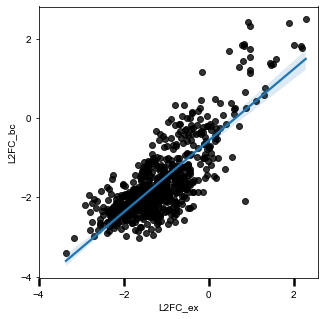

In [15]:
f, ax = plt.subplots(figsize = (5, 5))
sns.regplot(
    data = toplot, 
    x = 'L2FC_ex', 
    y = 'L2FC_bc', 
    scatter_kws = {'color': 'black'},
    ax = ax
)

ticks = [-4, -2, 0, 2]
ax.set_xticks(ticks)
ax.set_yticks(ticks)

f.savefig('PLOTS/Fig_S1A_barcode_extended.pdf', transparent = True)

## Figure 1E and Supplementary Figure 1C: piechart showing distribution of read assignments

In [2]:
# classify reads into 7 categories 
order = ['full_length',  
        'spliced',          
        'incomplete cloning',
        'panlidromic indel',              
        'mis-priming',                       
        'recombination',
        'ambiguous']   

def replace_category(cat):
    # function to rename reads into one of the categories
    if 'spliced' in cat:
        return 'spliced'
    elif 'AG_junction_high_mismatch' in cat or cat == 'ambiguous_deletion' or cat == 'unidentifiable_barcode':
        return 'ambiguous'
    elif cat == 'PRE-SPACER_mispriming' or cat == 'blank_mispriming':
        return 'mis-priming'
    elif cat == 'spacer_not_cloned' or cat == 'RE_not_cloned':
        return 'incomplete cloning'
    elif cat == 'RT_error':
        return 'panlidromic indel'
    elif cat == 'PCR_chimera':
        return 'recombination'
    else:
        return cat

def calculate_class_count(data):
    # function to count number of reads for each category
    df = pd.read_csv(data, sep = '\t')
    df['best_category'] = df['best_category'].apply(lambda g: replace_category(g))
    df = df.groupby('best_category')['count'].sum()
    #print(df)
    #print('total read count =', df.sum())
    df = df/df.sum()
    df = df.reindex(order)
    
    return df

In [3]:
# DNA plasmids
dna1 = calculate_class_count('ptreseq_raw_count/DNA-1_raw_count.txt')
dna2 = calculate_class_count('ptreseq_raw_count/DNA-2_raw_count.txt')

# calculate average percentage
dna = (dna1 + dna2)/2
dna

best_category
full_length           0.701464
spliced               0.000364
incomplete cloning    0.082181
panlidromic indel     0.000534
mis-priming           0.103413
recombination         0.072327
ambiguous             0.039718
Name: count, dtype: float64

In [4]:
# HELA (SSII)
hela1 = calculate_class_count('ptreseq_raw_count/HELA-1_raw_count.txt')
hela2 = calculate_class_count('ptreseq_raw_count/HELA-2_raw_count.txt')

# calculate average percentage
hela = (hela1 + hela2)/2
hela

best_category
full_length           0.299204
spliced               0.192836
incomplete cloning    0.173100
panlidromic indel     0.137171
mis-priming           0.076179
recombination         0.046513
ambiguous             0.074997
Name: count, dtype: float64

In [5]:
# HELA (Marathon RT)
mara1 = calculate_class_count('ptreseq_raw_count/ETOH-1_raw_count.txt')
mara2 = calculate_class_count('ptreseq_raw_count/ETOH-2_raw_count.txt')

# calculate average percentage
mara = (mara1 + mara2)/2
mara

best_category
full_length           0.295553
spliced               0.241250
incomplete cloning    0.105079
panlidromic indel     0.003189
mis-priming           0.081515
recombination         0.036380
ambiguous             0.237035
Name: count, dtype: float64

In [6]:
# HEK 293 (SSII)
hek1 = calculate_class_count('ptreseq_raw_count/HEK-1_raw_count.txt')
hek2 = calculate_class_count('ptreseq_raw_count/HEK-2_raw_count.txt')
hek3 = calculate_class_count('ptreseq_raw_count/HEK-3_raw_count.txt')

# calculate average percentage
hek = (hek1 + hek2 + hek3)/3
hek

best_category
full_length           0.362660
spliced               0.159286
incomplete cloning    0.153797
panlidromic indel     0.053758
mis-priming           0.074827
recombination         0.065642
ambiguous             0.130030
Name: count, dtype: float64

In [7]:
# SH-SY5Y (SSII)
sh1 = calculate_class_count('ptreseq_raw_count/SH-1_raw_count.txt')
sh2 = calculate_class_count('ptreseq_raw_count/SH-2_raw_count.txt')
sh3 = calculate_class_count('ptreseq_raw_count/SH-3_raw_count.txt')

# calculate average percentage
sh = (sh1 + sh2 + sh3)/3
sh

best_category
full_length           0.317403
spliced               0.168313
incomplete cloning    0.165334
panlidromic indel     0.056663
mis-priming           0.094319
recombination         0.061897
ambiguous             0.136071
Name: count, dtype: float64

In [8]:
# U87 (SSII)
u871 = calculate_class_count('ptreseq_raw_count/U87-1_raw_count.txt')
u872 = calculate_class_count('ptreseq_raw_count/U87-2_raw_count.txt')
u873 = calculate_class_count('ptreseq_raw_count/U87-3_raw_count.txt')

# calculate average percentage
u87 = (u871 + u872 + u873)/3
u87

best_category
full_length           0.355011
spliced               0.154052
incomplete cloning    0.159535
panlidromic indel     0.048148
mis-priming           0.089517
recombination         0.061727
ambiguous             0.132010
Name: count, dtype: float64

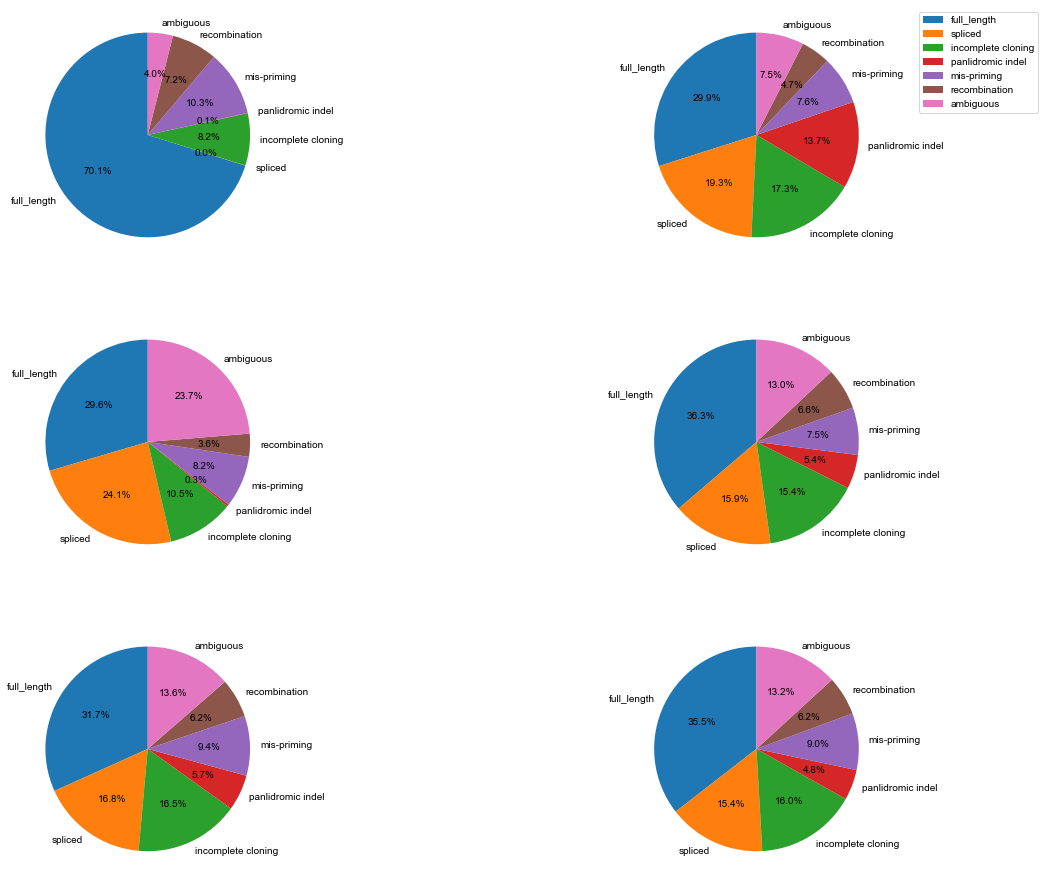

In [10]:
f, (top, middle, bottom) = plt.subplots(ncols = 2, nrows = 3, figsize = (20, 16))

# plot pie chart for all 6 samples
dna.plot.pie(y = 'count', ax = top[0], ylabel = '', startangle = 90, autopct='%1.1f%%') # Fig 1E
hela.plot.pie(y = 'count', ax = top[1], ylabel = '', startangle = 90, autopct='%1.1f%%') # Fig 1E
mara.plot.pie(y = 'count', ax = middle[0], ylabel = '', startangle = 90, autopct='%1.1f%%') # Fig S1C
hek.plot.pie(y = 'count', ax = middle[1], ylabel = '', startangle = 90, autopct='%1.1f%%') # Fig S1C
sh.plot.pie(y = 'count', ax = bottom[0], ylabel = '', startangle = 90, autopct='%1.1f%%') # Fig S1C
u87.plot.pie(y = 'count', ax = bottom[1], ylabel = '', startangle = 90, autopct='%1.1f%%') # Fig S1C
     
top[0].legend(bbox_to_anchor = (4, 1))

f.savefig('PLOTS/Fig_S1C.pdf', transparent = True)

## Figure S1E: comparison between SuperScript II and Marathon

In [2]:
HELA = pd.read_csv('ptreseq_splicing_quantification/HELA_2rep_fraction.txt', sep = '\t')
fHELA = HELA[HELA['best_category']=='full_length'].reset_index(drop = True)
fHELA['fraction'] = 1 - fHELA['fraction']

MARA = pd.read_csv('ptreseq_splicing_quantification/HELA-mara_2rep_fraction.txt', sep = '\t')
fMARA = MARA[MARA['best_category']=='full_length'].reset_index(drop = True)
fMARA['fraction'] = 1 - fMARA['fraction']

merged = fHELA.merge(fMARA, on = ['RE', 'best_category'], suffixes = ('_ssii', '_mara'))
#merged.corr(numeric_only = True)
merged.corr()

,fraction_ssii,fraction_mara
fraction_ssii,1.000000,0.952724
fraction_mara,0.952724,1.000000


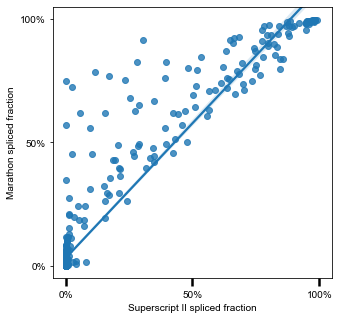

In [3]:
# regplot
f, ax = plt.subplots(figsize = (5, 5))

sns.regplot(data = merged, x = 'fraction_ssii', y = 'fraction_mara', ax = ax)

ax.set_xlabel('Superscript II spliced fraction')
ax.set_ylabel('Marathon spliced fraction')

ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

ax.set_xticks([0, 0.5, 1.0])
ax.set_xticklabels(['0%', '50%', '100%'])

ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0%', '50%', '100%'])

f.savefig('PLOTS/Fig_S1G_SSII_Mara.pdf')

## Figure 1F: reproducibility between biological replicates of HeLa (SSII) sample

In [2]:
def process_raw_count(fn, sample):
    df = pd.read_csv(fn, sep = '\t')
    df = df[(df['best_category'].str.contains('full_length'))|(df['best_category'].str.contains('spliced'))].reset_index(drop = True)
    df['best_category'] = df['best_category'].apply(lambda g: g.split('-')[1] if 'spliced' in g else g)
    
    # get total count for each reporter and remove reporters with count less than 10
    total_count = df.groupby('reporter')['count'].sum()
    reporter_less_than_10 = total_count[total_count<=10].index
    filtered_df = df[~df['reporter'].isin(reporter_less_than_10)].reset_index(drop = True)
    
    # calculate fraction for each isoform
    filtered_df['fraction'] = filtered_df.groupby('reporter', group_keys=False)['count'].apply(lambda g: g/g.sum())
    # calculate fraction over barcode replicates
    filtered_df['RE'] = filtered_df['reporter'].apply(lambda g: g.split('_')[0])
    
    return filtered_df

def filter_barcode_count(df, threshold):
    # filter out reporters with less than 2 internal barcodes
    full_df = df[df['best_category']=='full_length']
    
    RE_count = full_df['RE'].value_counts()
    reporter_less_than_3_count = RE_count[RE_count<=threshold].index
    filtered_df = full_df[~full_df['RE'].isin(reporter_less_than_3_count)].reset_index(drop = True)
    
    return filtered_df

In [3]:
# import raw count
hela1count = process_raw_count('ptreseq_raw_count/HELA-1_raw_count.txt', 'hela1')
hela2count = process_raw_count('ptreseq_raw_count/HELA-2_raw_count.txt', 'hela2')
# merge dataframe
hela = hela1count.merge(hela2count, on = ['reporter', 'RE', 'best_category'], how = 'inner')
hela = hela.rename(columns = {
                        'count_x': 'HELA-1_count',
                        'fraction_x': 'HELA-1_fraction',
                        'count_y': 'HELA-2_count',
                        'fraction_y': 'HELA-2_fraction'
                            })
# filter out reporters with less than 2 internal barcodes
hela_filtered = filter_barcode_count(hela, 2)
# compute median splicing fraction
hela_filtered = hela_filtered.groupby('RE')[['HELA-1_fraction', 'HELA-2_fraction']].median()
# splicing fraction = 1 - full length fraction
hela_filtered['HELA-1'] = 1 - hela_filtered['HELA-1_fraction']
hela_filtered['HELA-2'] = 1 - hela_filtered['HELA-2_fraction']

          HELA-1    HELA-2
HELA-1  1.000000  0.977734
HELA-2  0.977734  1.000000


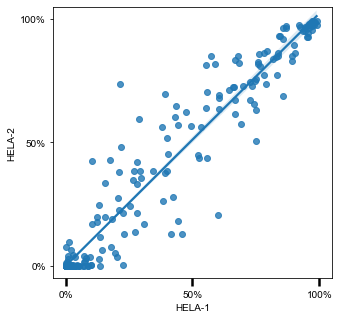

In [11]:
# plot correlation between 2 hela biological replicates
f, ax = plt.subplots(figsize = (5, 5))

print(hela_filtered[['HELA-1', 'HELA-2']].corr())

sns.regplot(data = hela_filtered, x = 'HELA-1', y = 'HELA-2', ax = ax)

ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

ax.set_xticks([0, 0.5, 1.0])
ax.set_xticklabels(['0%', '50%', '100%'])

ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0%', '50%', '100%'])

f.savefig('PLOTS/Fig_S1H_HeLa_bio_rep.pdf')

## Supplementary Figure 1G: mean absolute deviation between barcodes

In [4]:
# calculate mean absolute deviation
hela_concat = pd.concat([hela1count, hela2count])
hela_concat_fl = hela_concat[hela_concat['best_category']=='full_length'].reset_index(drop = True)
hela_concat_fl['spliced_fraction'] = 1 - hela_concat_fl['fraction']
hela_concat_fl_mad = hela_concat_fl.groupby('RE')['spliced_fraction'].apply(
    lambda g: (g - g.mean()).abs().mean())

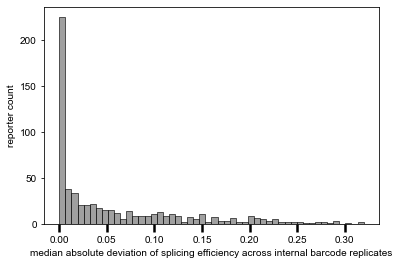

In [14]:
# plot histogram
f, ax = plt.subplots()

sns.histplot(x = hela_concat_fl_mad, color = 'grey', bins = 50, ax = ax)

ax.set_xlabel('median absolute deviation of splicing efficiency across internal barcode replicates')
ax.set_ylabel('reporter count')

f.savefig('PLOTS/Fig_S1H_barcode_MAD.pdf')